In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_ship_DN.csv",encoding="shift-jis",index_col=0)
# sum ver.
# df=pd.read_csv("../data/merged/len3_ship_sum_DN.csv",encoding="shift-jis",index_col=0)

Estimation

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"]+0.001)
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"]+0.001)
df["year_trend"]=df["year"]-2008

In [5]:
df=df.set_index(["id","year"])
df.info()
# make this to paneldata
df=PanelData(df)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 260 entries, (114, 2008) to (799, 2021)
Data columns (total 99 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   efficacy           260 non-null    object 
 1   rx_dom             260 non-null    int64  
 2   otc_dom            260 non-null    float64
 3   self_dom           260 non-null    int64  
 4   stock_rx           260 non-null    float64
 5   stock_otc          260 non-null    float64
 6   stock_self         260 non-null    float64
 7   stock_rx_lag       242 non-null    float64
 8   stock_otc_lag      242 non-null    float64
 9   stock_self_lag     242 non-null    float64
 10  Approved           260 non-null    float64
 11  KEGG               260 non-null    object 
 12  Ingredient         260 non-null    object 
 13  date               260 non-null    object 
 14  release_year       260 non-null    float64
 15  成分                 260 non-null    object 
 16  variable

(184, 14, 21)

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [6]:
# formula="rx_dom ~ year_trend+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+generic_per+TimeEffects+EntityEffects"
# # stock lag version
# # formula+="+stock_rx_lag"
# # gemeric_per
# formula+=" + generic_per"
# mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
# res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# # print(res_fe.summary.tables[1])
# # print(res_fe.summary.tables[0])
# print(res_fe)
# plot_result(res_fe,file_name="rx",title="rx",period=25,insert_index=9,time_start=-10)
# # print(x)

In [7]:
[0]*5

[0, 0, 0, 0, 0]

                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
elapsed_m10         -0.1156     0.0893    -1.2956     0.1968     -0.2917      0.0605
elapsed_m9          -0.0994     0.1179    -0.8427     0.4005     -0.3320      0.1333
elapsed_m8          -0.0736     0.0850    -0.8661     0.3876     -0.2413      0.0941
elapsed_m7           0.0162     0.0796     0.2034     0.8391     -0.1408      0.1732
elapsed_m6           0.0490     0.0681     0.7202     0.4723     -0.0853      0.1833
elapsed_m5           0.1085     0.0692     1.5681     0.1186     -0.0280      0.2449
elapsed_m4           0.0775     0.0473     1.6405     0.1026     -0.0157      0.1708
elapsed_m3           0.0405     0.0352     1.1506     0.2514     -0.0290      0.1101
elapsed_m2           0.0506     0.0518     0.9752     0.3308     

c:\Users\hakos\AppData\Local\Programs\Python\Python310\lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\hakos\AppData\Local\Temp\ipykernel_20120\2796508845.py:16: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

year_trend, generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


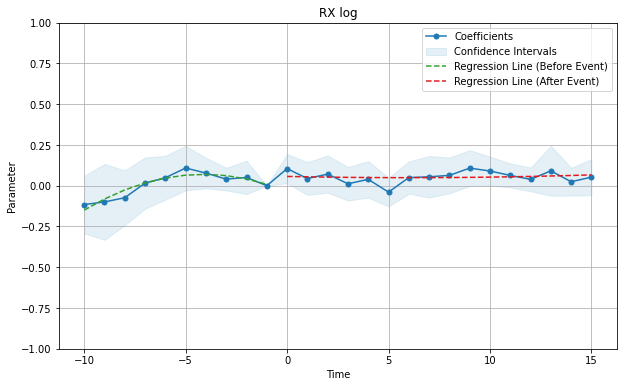

In [8]:
# take log
formula="log_rx_dom ~ year_trend+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+TimeEffects+EntityEffects"
# stock lag version
formula+="+log_stock_rx_lag"

# generic_per
formula+=" + generic_per"

# generic_share_r
formula+=" + generic_share_r"

# generic_share_q
formula+=" + generic_share_q"

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log",title="RX log",period=25,insert_index=9,time_start=-10)

### OTC

In [9]:

# formula="otc_dom ~ year_trend+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+generic_per+TimeEffects+EntityEffects"
# # stock lag version
# # formula+="+stock_otc_lag"
# # gemeric_per
# formula+=" + generic_per"
# mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=True)
# # mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=False)
# res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
# plot_result(res_fe,file_name="otc",title="OTC",period=25,insert_index=9,time_start=-10)

c:\Users\hakos\AppData\Local\Programs\Python\Python310\lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\hakos\AppData\Local\Temp\ipykernel_20120\1831722513.py:22: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:            log_otc_dom   R-squared:                        0.3255
Estimator:                   PanelOLS   R-squared (Between):              0.1471
No. Observations:                 242   R-squared (Within):               0.3169
Date:                Tue, Sep 19 2023   R-squared (Overall):              0.1499
Time:                        22:58:07   Log-likelihood                   -158.07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.1195
Entities:                          21   P-value                           0.0000
Avg Obs:                       11.524   Distribution:                  F(28,181)
Min Obs:                       1.0000                                           
Max Obs:                       13.000   F-statistic (robust):           -3.6e+14
                            

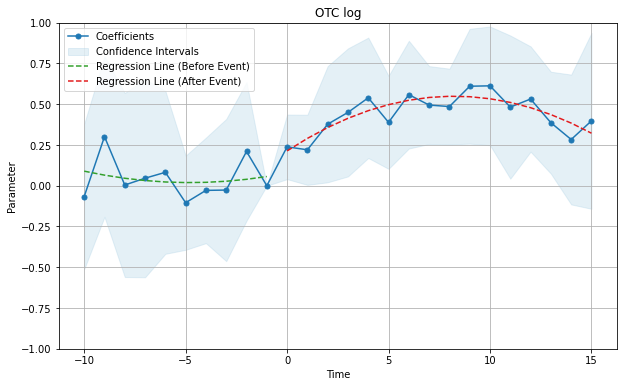

In [10]:
# take log
formula="log_otc_dom ~elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+generic_per+TimeEffects+EntityEffects"

# till 15
formula="log_otc_dom ~elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+TimeEffects+EntityEffects"

# stock lag version
formula+="+log_stock_otc_lag"

# year trend
# formula+="+year_trend"

# gemeric_per
formula+=" + generic_per"

# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
plot_result(res_fe,file_name="otc_log",title="OTC log",period=25,insert_index=9,time_start=-10)